# Kernel-Length Regularization
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_02_CNN_faces_houses.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_02_CNN_faces_houses.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime


try:
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
            
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    
    plt.style.use('dark_background')
    IN_COLAB = True
    
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")
        

import tensorflow as tf
from indl import turbo_cmap, reset_keras
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18
})
%load_ext autoreload
%autoreload 2

## Introduction

A common step in many signal processing pipelines to analyze neurophysiological time series is time domain convolution. For example, band-pass filtering EEG to yield beta oscillatory activity, or smoothing spike trains to yield firing rates, are both time-domain convolution operations. Depending on the task and the data content, it may be desirable to perform multiple different kernel convolutions, e.g., filter bank analysis of EEG to yield the traditional bands (delta, theta, alpha, beta, gamma), or to demultiplex spike trains into 'isolated event rates' and 'burst rates'.

The convolution kernels are typically predetermined according to the demands of the processing step. FIR filter-design tools provide filter kernels that optimally pass certain frequencies, stop other frequencies, all while minimizing other features like ripple or phase-delay. While the traditional EEG frequency ranges may be a good starting point, optimal frequency-bands are subject-specific and may not fall precisely within the traditional bands. Thus we might getter better performance from our analysis pipeline if we optimize the set of kernels for the data and task at hand. Optimizing convolution kernels is exactly what deep learning with CNNs does, so we can co-opt the CNN machinery to learn our convolution filter kernels for us. This is a common approach and is part of the motivation for the architecture used in EEGNet.

An important performance-related parameter for designing filter kernels is the kernel length. Longer kernels are required to capture slowly changing features, they may have sharper frequency roll off in the transitions between passed bands and stopped bands, but they require more computation and create more delay in the output signal. Furthermore, longer kernels have more paramters and are therefore more likely to overfit trivial features in the training data, hindering generalization.

Convolutional layers built-in to deep learning frameworks already have mechanisms for regularization to try to prevent overfitting, but these work by keeping the kernel weights sparse (near zero), without much regard for whether this effectively shortens the kernel length. In this work we develop and validate a method of regularization that puts pressure on minimizing kernel length.

## Method

### Test Data
In our first series of tests, we will use simulated data with several pure sine waves and white noise. The first test in this series will attempt to reconstruct only one of the sinusoids and the others are considered nuisance signals. In subsequent tests we will attempt to reconstruct two of the sinusoids.

In [2]:
fs = 512.0            # samples per second
dur = 1.0             # duration in seconds
freqs = [8, 13, 18, 65, 75, 85]  # Peak frequencies, in Hz
reconstruct = [75]
n_trials = 2000
noise_amp = 0.3
max_kernel_length = 300
n_epochs = 5
batch_size = 5

In [3]:
import scipy.signal

n_samples = int(dur * fs)
t = np.arange(n_samples) / fs  # Timestamp vector

def gen_signal(_t, _freqs, _reconstruct):
    x = np.zeros_like(_t)
    y = np.zeros((len(_t), len(_reconstruct)))
    for ff in _freqs:
        temp = np.sin(2*np.pi*ff*_t + 2*np.pi*np.random.rand())
        x = x + temp
        if ff in _reconstruct:
            y[:, _reconstruct.index(ff)] = temp
    x = x + noise_amp * np.random.randn(*x.shape)
    x = x.reshape(len(_t), 1, 1).astype(np.float32)
    y = y.reshape(len(_t), len(_reconstruct), 1).astype(np.float32)
    return x, y

def gen_dataset(_n_trials, _t, _freqs, _reconstruct, _batch_size):
    X = []
    Y = []
    for tr_idx in range(_n_trials):
        x, y = gen_signal(_t, _freqs, _reconstruct)
        X.append(x)
        Y.append(y)

    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(_n_trials).batch(_batch_size).repeat()
    return dataset

dataset = gen_dataset(n_trials, t, freqs, reconstruct, batch_size)

0


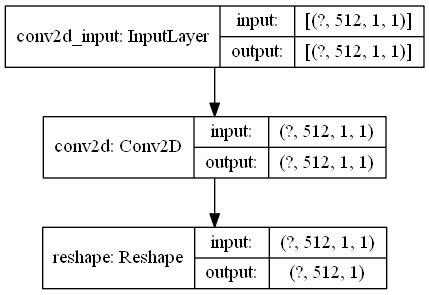

In [4]:
def gen_model(_n_samples, _max_kernel_length, _reconstruct,
              _regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=0.0)):
    reset_keras()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(len(_reconstruct), (_max_kernel_length, 1),
                                     padding='same', activation='linear', use_bias=False,
                                     kernel_regularizer=_regularizer,
                                     input_shape=(n_samples, 1, 1)))
    model.add(tf.keras.layers.Reshape((_n_samples, len(_reconstruct))))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

model = gen_model(n_samples, max_kernel_length, reconstruct)
tf.keras.utils.plot_model(model, show_shapes=True)

In [5]:
history = model.fit(x=dataset, epochs=n_epochs,
                    steps_per_epoch=n_trials // batch_size,
                    verbose=1)

Train for 400 steps
Epoch 1/5
400/400 [==============================] - 2s 6ms/step - loss: 0.0989
Epoch 2/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0160
Epoch 3/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 4/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0133
Epoch 5/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0133


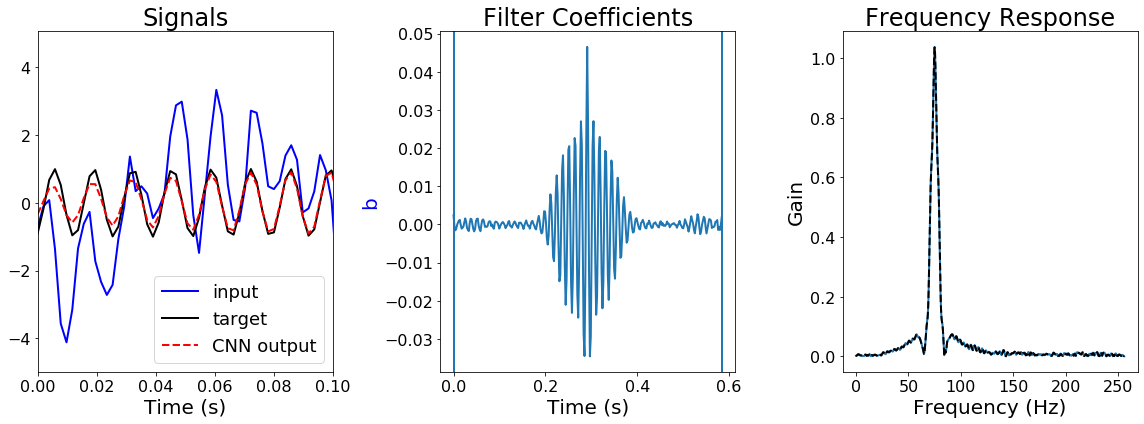

In [6]:
def plot_kern_weights(_model, _t, _freqs, _reconstruct, threshold=None):
    coefs = _model.layers[0].get_weights()[0]
    coefs = coefs.reshape(coefs.shape[0], coefs.shape[-1])

    # Plot filter design
    plt.figure(figsize=(16, 6))

    # Plot signals
    plt.subplot(1, 3, 1)

    x, y = gen_signal(_t, _freqs, _reconstruct)
    y_cnn = model.predict(x[None,])
    plt.plot(t, x.reshape(len(_t),), 'b', label='input')
    plt.plot(t, y.reshape(len(_t), len(_reconstruct)), 'r', label='target')
    plt.plot(t, y_cnn.reshape(len(_t), len(_reconstruct)), 'k', linestyle='--', label='CNN output')
    plt.xlabel('Time (s)')
    plt.xlim([0, 0.1])
    plt.legend(loc='lower right')
    plt.title('Signals')

    # Filter coefficients
    plt.subplot(1, 3, 2)
    coef_x = np.arange(coefs.shape[0]) / fs
    plt.plot(coef_x, coefs)
    plt.xlabel('Time (s)')
    plt.ylabel('b', color='b')
    plt.title('Filter Coefficients')
    if threshold is not None:
        over_thresh_inds = np.where(np.abs(coefs) > threshold)
        b_0 = over_thresh_inds[1] == 0
        inds_0 = np.array([over_thresh_inds[0][b_0][0], over_thresh_inds[0][b_0][-1]])
        plt.axvline(coef_x[inds_0[0]])
        plt.axvline(coef_x[inds_0[1]])
        b_1 = over_thresh_inds[1] == 1
        if np.any(b_1):
            inds_1 = np.array([over_thresh_inds[0][b_1][0], over_thresh_inds[0][b_1][-1]])
            plt.axvline(coef_x[inds_1[0]], color='r')
            plt.axvline(coef_x[inds_1[1]], color='r')

    # Frequency response
    plt.subplot(1, 3, 3)
    for coef_ix in range(coefs.shape[-1]):
        w, h = scipy.signal.freqz(coefs[:, coef_ix], 1.0, worN=2000)  # frequency response
        plt.plot((fs * 0.5 / np.pi) * w, abs(h))
        if threshold is not None:
            n_coefs = coefs.shape[0]
            cut_ix = int((n_coefs // 2) - np.max(np.abs(inds_0 - n_coefs // 2)))
            cut_stop = max(cut_ix, 1)
            w, h = scipy.signal.freqz(coefs[cut_ix:-cut_stop, coef_ix], 1.0, worN=2000)  # frequency response
            plt.plot((fs * 0.5 / np.pi) * w, abs(h), 'k--')
            if np.any(b_1):
                cut_ix = int((n_coefs // 2) - np.max(np.abs(inds_1 - n_coefs // 2)))
                cut_stop = max(cut_ix, 1)
                w, h = scipy.signal.freqz(coefs[cut_ix:-cut_stop, coef_ix], 1.0, worN=2000)  # frequency response
                plt.plot((fs * 0.5 / np.pi) * w, abs(h), 'k--')
                
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.title('Frequency Response')
    plt.tight_layout()

    plt.tight_layout()
    plt.show()
    
plot_kern_weights(model, t, freqs, reconstruct, threshold=0.0015)

### Custom Regularizer

In [7]:
class KernelLengthRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, kernel_size, window_scale=1e-2, window_func='poly', poly_exp=2, threshold=tf.keras.backend.epsilon()):
        self.kernel_size = kernel_size
        self.window_scale = window_scale
        self.window_func = window_func
        self.poly_exp = poly_exp
        self.threshold=threshold
        self.rebuild_window()
        
    def rebuild_window(self):
        windows = []
        for win_dim, win_len in enumerate(self.kernel_size):
            if win_len == 1:
                window = np.ones((1,), dtype=np.float32)
            else:
                if self.window_func == 'hann':
                    window = 1 - tf.signal.hann_window(win_len, periodic=False)
                elif self.window_func == 'hamming':
                    window = 1 - tf.signal.hamming_window(win_len, periodic=False)
                else:  # if window_func == 'linear':
                    hl = win_len // 2
                    window = np.zeros((win_len,), dtype=np.float32)
                    window[:hl] = np.arange(1, hl+1)[::-1]  # Negative slope line to 0 for first half.
                    window[-hl:] = np.arange(1, hl+1)       # Positive slope line from 0 for second half.
                    window = window / hl                    # Scale so it's -1 -- 0 -- 1
                    window = window**self.poly_exp          # Exponent
                
            win_shape = [1] * (len(self.kernel_size) + 2)
            win_shape[win_dim] = win_len
            window = tf.reshape(window, win_shape)
            windows.append(window)
            
        self.window = tf.linalg.matmul(*windows)
        self.window = self.window / tf.reduce_max(self.window)
        
    def get_config(self):
        return {'kernel_size': self.kernel_size,
                'window_scale': self.window_scale,
                'window_func': self.window_func,
                'poly_exp': self.poly_exp,
                'threshold': self.threshold}
    
    def __call__(self, weights):
        # non_zero = tf.cast(tf.abs(weights) > self.threshold, tf.float32)
        non_zero = tf.nn.sigmoid(tf.abs(weights) - self.threshold)
        # non_zero = tf.abs(weights)
        regularization = self.window_scale * self.window * non_zero
        # regularization = tf.reduce_max(regularization, axis=[0, 1], keepdims=True)
        regularization = tf.reduce_sum(regularization)
        return regularization

9159


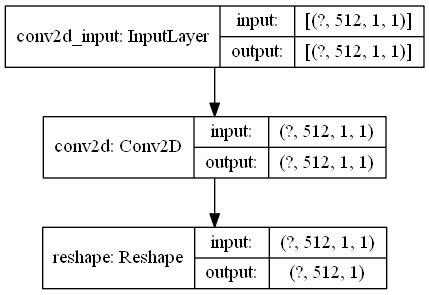

In [8]:
regularizer = KernelLengthRegularizer((max_kernel_length, 1),
                                      window_func='poly', window_scale=0.1, poly_exp=2, threshold=0.0015)
# regularizer = tf.keras.regularizers.L1L2(l1=0.1, l2=0.1)  # For comparison, try l1l2 regularizations.
model = gen_model(n_samples, max_kernel_length, reconstruct, _regularizer=regularizer)
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
history = model.fit(x=dataset, epochs=n_epochs,
                    steps_per_epoch=n_trials // batch_size,
                    verbose=1)

Train for 400 steps
Epoch 1/5
400/400 [==============================] - 1s 3ms/step - loss: 5.1308
Epoch 2/5
400/400 [==============================] - 1s 2ms/step - loss: 5.0621
Epoch 3/5
400/400 [==============================] - 1s 2ms/step - loss: 5.0615
Epoch 4/5
400/400 [==============================] - 1s 2ms/step - loss: 5.0615
Epoch 5/5
400/400 [==============================] - 1s 2ms/step - loss: 5.0614


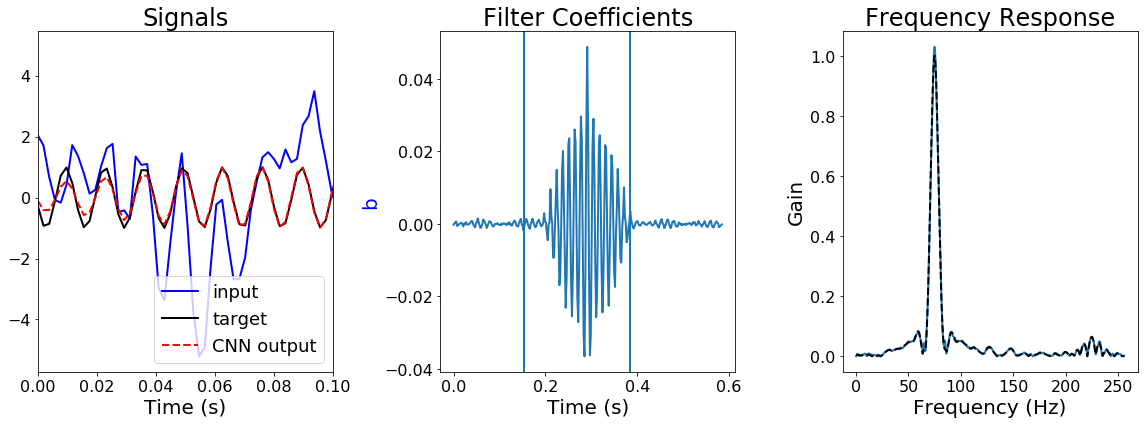

In [10]:
plot_kern_weights(model, t, freqs, reconstruct, threshold=0.0015)

### Reconstruct Two Signals

In [11]:
reconstruct = [13, 75]
dataset = gen_dataset(n_trials, t, freqs, reconstruct, batch_size)

#### Without custom regularizer

39861
Train for 400 steps
Epoch 1/5
400/400 [==============================] - 1s 3ms/step - loss: 0.0713
Epoch 2/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0176
Epoch 3/5
400/400 [==============================] - 1s 3ms/step - loss: 0.0160
Epoch 4/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0158
Epoch 5/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0158


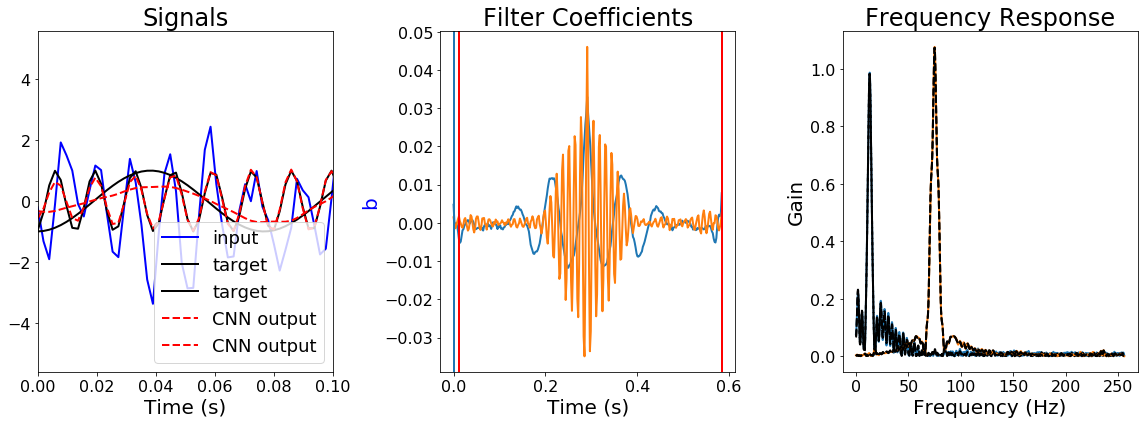

In [12]:
regularizer = tf.keras.regularizers.L1L2(l1=0.00, l2=0.00)
model = gen_model(n_samples, max_kernel_length, reconstruct, _regularizer=regularizer)
history = model.fit(x=dataset, epochs=n_epochs,
                    steps_per_epoch=n_trials // batch_size,
                    verbose=1)
plot_kern_weights(model, t, freqs, reconstruct, threshold=0.0015)

#### With custom regularizer

42204
Train for 400 steps
Epoch 1/5
400/400 [==============================] - 1s 3ms/step - loss: 30.4160
Epoch 2/5
400/400 [==============================] - 1s 2ms/step - loss: 30.3067
Epoch 3/5
400/400 [==============================] - 1s 3ms/step - loss: 30.3065
Epoch 4/5
400/400 [==============================] - 1s 2ms/step - loss: 30.3065
Epoch 5/5
400/400 [==============================] - 1s 2ms/step - loss: 30.3065


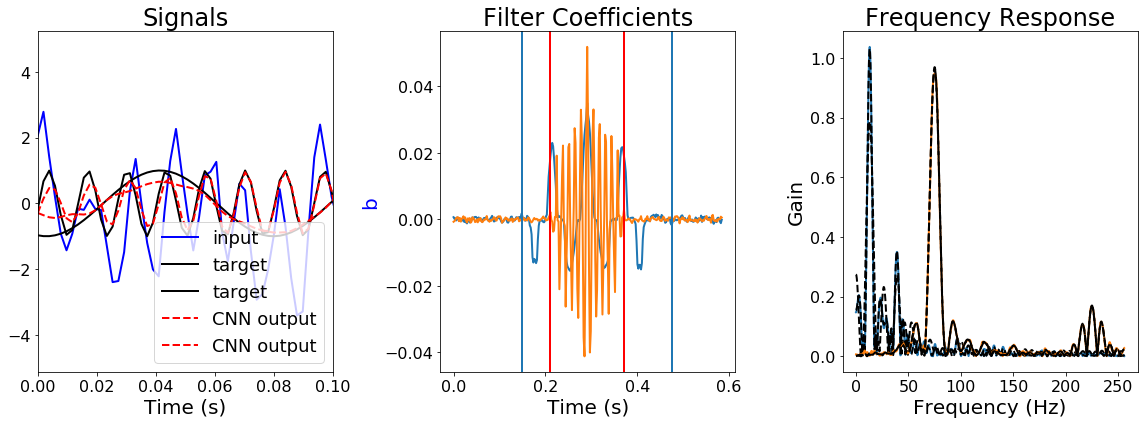

In [13]:
regularizer = KernelLengthRegularizer((max_kernel_length, 1), window_func='poly',
                                      poly_exp=2.0, window_scale=0.3, threshold=0.0015)
model = gen_model(n_samples, max_kernel_length, reconstruct, _regularizer=regularizer)
history = model.fit(x=dataset, epochs=n_epochs,
                    steps_per_epoch=n_trials // batch_size,
                    verbose=1)
plot_kern_weights(model, t, freqs, reconstruct, threshold=0.0015)